In [1]:
from python_speech_features import mfcc
import scipy.io.wavfile as wav
import numpy as np
import os
import pickle
import random
import operator
from tempfile import TemporaryFile
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

In [4]:
def distance(instance1, instance2, k):
    distance = 0
    mm1, cm1 = instance1[0], instance1[1]
    mm2, cm2 = instance2[0], instance2[1]
    distance = np.trace(np.dot(np.linalg.inv(cm2), cm1))
    distance += np.dot(np.dot((mm2 - mm1).transpose(), np.linalg.inv(cm2)), mm2 - mm1)
    distance += np.log(np.linalg.det(cm2)) - np.log(np.linalg.det(cm1))
    distance -= k
    return distance

In [5]:
def getNeighbors(trainingSet, instance, k):
    distances = []
    for x in range(len(trainingSet)):
        dist = distance(trainingSet[x], instance, k) + distance(instance, trainingSet[x], k)
        distances.append((trainingSet[x][2], dist))
    distances.sort(key=operator.itemgetter(1))
    neighbors = []
    for x in range(k):
        neighbors.append(distances[x][0])
    return neighbors

In [6]:
def nearestClass(neighbors):
    classVote = {}
    for x in range(len(neighbors)):
        response = neighbors[x]
        if response in classVote:
            classVote[response] += 1
        else:
            classVote[response] = 1

    sorter = sorted(classVote.items(), key=operator.itemgetter(1), reverse=True)
    return sorter[0][0]

In [7]:
def getAccuracy(testSet, predictions):
    correct = 0
    for x in range(len(testSet)):
        if testSet[x][-1] == predictions[x]:
            correct += 1
    return 1.0 * correct / len(testSet)

In [14]:
# Assuming genres is a list of genre names
genres = ["Blues", "Classical", "Country", "Disco", "Hiphop", "Jazz", "Matal", "Pop", "Reggae", "Rock"]

In [15]:
directory = "/home/ankit/project/archive/Data/genres_original/"
f = open("my.dat", 'wb')
i = 0

for folder in os.listdir(directory):
    i += 1
    if i == 11:
        break
    for file in os.listdir(directory + folder):
        (rate, sig) = wav.read(directory + folder + "/" + file)
        mfcc_feat = mfcc(sig, rate, winlen=0.020, appendEnergy=False)
        covariance = np.cov(np.matrix.transpose(mfcc_feat))
        mean_matrix = mfcc_feat.mean(0)
        feature = (mean_matrix, covariance, i)
        pickle.dump(feature, f)

f.close()


In [16]:
# Load the dataset
dataset = []
def loadDataset(filename, split, trSet, teSet):
    with open("my.dat", 'rb') as f:
        while True:
            try:
                dataset.append(pickle.load(f))
            except EOFError:
                f.close()
                break
    for x in range(len(dataset)):
        if random.random() < split:
            trSet.append(dataset[x])
        else:
            teSet.append(dataset[x])

In [17]:
# Create training and testing sets
trainingSet = []
testSet = []
loadDataset("my.dat", 0.66, trainingSet, testSet)

In [18]:
# Perform k-NN classification
leng = len(testSet)
predictions = []
true_labels = [instance[-1] for instance in testSet]

for x in range(leng):
    predictions.append(nearestClass(getNeighbors(trainingSet, testSet[x], 5)))


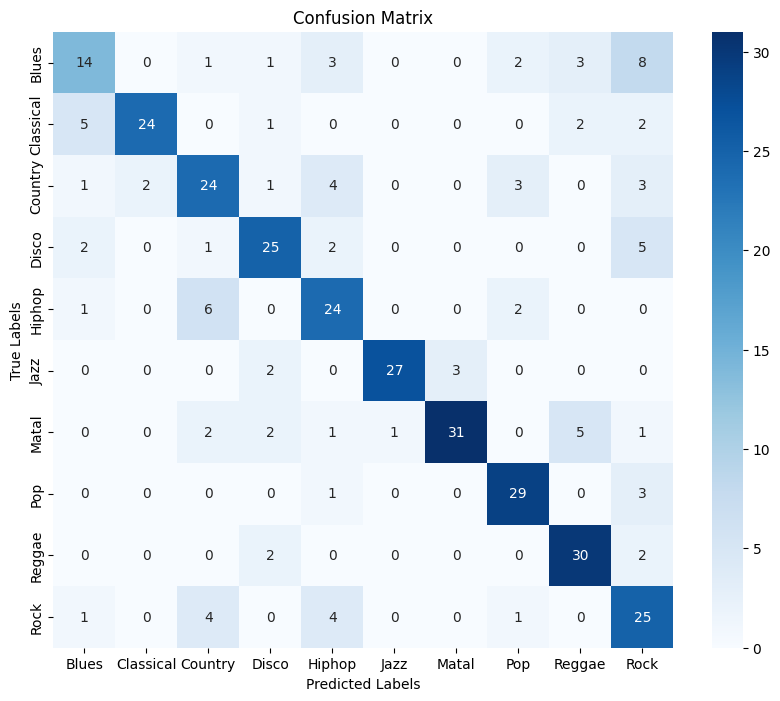

In [19]:
# Calculate and plot the confusion matrix
conf_matrix = confusion_matrix(true_labels, predictions)

plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=genres, yticklabels=genres)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

/tmp/ipykernel_13561/3120453175.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='genre', data=df, palette='viridis')


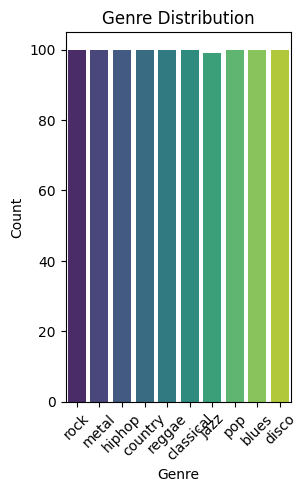

In [23]:
import pandas as pd

# Load your dataset into a DataFrame
directory = "/home/ankit/project/archive/Data/genres_original/"
data = []

for folder in os.listdir(directory):
    for file in os.listdir(directory + folder):
        (rate, sig) = wav.read(directory + folder + "/" + file)
        mfcc_feat = mfcc(sig, rate, winlen=0.020, appendEnergy=False)
        covariance = np.cov(np.matrix.transpose(mfcc_feat))
        mean_matrix = mfcc_feat.mean(0)
        feature = {"mean_matrix": mean_matrix, "covariance": covariance, "genre": folder}
        data.append(feature)

df = pd.DataFrame(data)

# Bar Plot of Genre Distribution
plt.subplot(1, 2, 2)
sns.countplot(x='genre', data=df, palette='viridis')
plt.title('Genre Distribution')
plt.xlabel('Genre')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()


In [22]:
# Calculate and print accuracy
accuracy1 = getAccuracy(testSet, predictions)
print("Accuracy:", accuracy1)

Accuracy: 0.7249283667621776
